**Score: 1.86009**

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/"
from google.colab import drive
drive.mount('/content/drive')

In [7]:
import tensorflow as tf
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Create a TensorFlow configuration object
tf_config = tf.compat.v1.ConfigProto()

# Set the device count to control how many devices TensorFlow uses
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.5  # Limit to 50% of GPU memory usage
tf_config.gpu_options.allow_growth = True  # Allow memory growth

# Set TensorFlow's configuration
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=tf_config))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

Num GPUs Available:  1
Physical devices cannot be modified after being initialized


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset
!kaggle competitions download -c facial-keypoints-detection
!unzip '/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset/facial-keypoints-detection.zip' -d '/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset'
!unzip '/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset/training.zip' -d '/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset'
!unzip '/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset/test.zip' -d '/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset'


In [8]:
import pandas as pd

In [9]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset/training.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset/test.csv')

train_data = train_data.fillna(0)

import numpy as np

def create_image(text):
  ptext= [int(num) for num in text.split()]
  ptext=np.array(ptext)
  ptext=np.reshape(ptext,(96,96))
  return ptext

images=[]
for image in train_data['Image']:
  image=create_image(image)
  images.append(image)
test_images=[]
for image in test_data['Image']:
  image=create_image(image)
  test_images.append(image)

images=np.array(images)/255.
test_images=np.array(test_images)/255.

train_data=train_data.drop("Image", axis=1)
train_data/=96
train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,0.687850,0.406274,0.314865,0.379392,0.620647,0.412994,0.761774,0.416354,0.378714,0.389473,...,0.462714,0.594446,0.637451,0.833023,0.298068,0.806135,0.451173,0.759744,0.449278,0.880060
1,0.670135,0.364272,0.311972,0.348424,0.613085,0.367441,0.736695,0.376950,0.375362,0.357933,...,0.502149,0.579801,0.587723,0.795333,0.365858,0.792163,0.486298,0.731943,0.473624,0.890418
2,0.677678,0.363642,0.321914,0.363642,0.618875,0.378343,0.739421,0.378343,0.392480,0.378343,...,0.495388,0.557697,0.633572,0.760566,0.351316,0.757625,0.492447,0.731164,0.492447,0.819368
3,0.679435,0.388143,0.333574,0.388143,0.625035,0.407575,0.753278,0.399802,0.391861,0.403689,...,0.540470,0.564235,0.683322,0.757330,0.387974,0.772870,0.523991,0.730122,0.537096,0.815296
4,0.695055,0.412721,0.335883,0.396271,0.610061,0.412721,0.755374,0.415463,0.385233,0.407238,...,0.451037,0.675933,0.631994,0.807534,0.324914,0.802055,0.468362,0.767785,0.460699,0.904908


In [75]:
# import the necessary packages
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.losses import Loss
import tensorflow as tf

def mape(y_true, y_pred):
    mask = tf.cast(y_true != 0, tf.float64)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    loss_fn = MeanAbsolutePercentageError()
    loss = loss_fn(y_true_masked, y_pred_masked)

    return loss

class MaskedLoss(Loss):
	def __init__(self):
		# initialize the name of the loss and the loss function
		self.name = "masked_loss"
		self.loss = MeanAbsolutePercentageError()


	def call(self, yTrue, yPred):
		# calculate the loss for each item in the batch
		loss = self.loss(yTrue, yPred)

		# mask off the losses on padding
		mask = tf.cast(yTrue != 0, tf.float64)
		loss *= mask
		# return the total loss
		return tf.reduce_sum(loss)


In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input,ReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy as keras_legacy_optimizers
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

checkpoint_callback = ModelCheckpoint(filepath='detection_model.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)

def get_model(filters=[32,64,128,256,512,1028,2048]):
  input=Input(shape=(96,96,1))
  x=input
  for f in filters:
    x=Conv2D(f,(3,3),strides=2,padding="same")(x)
    x=ReLU()(x)
    x=BatchNormalization(axis=-1)(x)
  x=Flatten()(x)
  x=Dense(1024,activation="relu")(x)
  x=Dropout(0.2)(x)
  x=Dense(512,activation="relu")(x)
  x=Dropout(0.2)(x)
  x=Dense(256,activation="relu")(x)
  x=Dropout(0.2)(x)
  x=Dense(128,activation="relu")(x)
  x=Dropout(0.2)(x)
  output=Dense(30,activation="sigmoid")(x)
  detection_model=Model(inputs=[input],outputs=[output],name="detection_model")
  return detection_model


detection_model=get_model()
detection_model.summary()


Model: "detection_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 24, 24, 64)        0         
                                                   

In [ ]:
from sklearn.model_selection import train_test_split
# train_x, val_x, train_y, val_y  = train_test_split(images,DATASET, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y  = train_test_split(images,train_data, test_size=0.2, random_state=42)
epochs=500
#opt=Adam(0.001)
opt = keras_legacy_optimizers.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
detection_model.compile(loss=mape, optimizer=opt)
#mean_absolute_percentage_error
H=detection_model.fit(x=train_x, y=train_y,
	validation_data=(val_x, val_y),
	epochs=epochs, batch_size=64,
	callbacks=[checkpoint_callback])

In [ ]:
detection_model=load_model("/content/detection_model.h5")

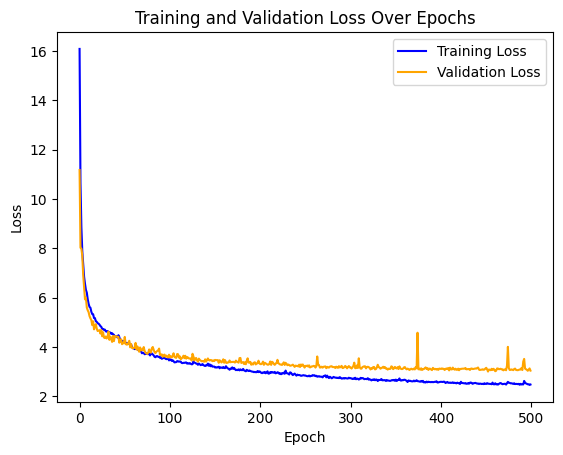

In [88]:
import matplotlib.pyplot as plt

plt.plot(H.history['loss'], label='Training Loss', color='blue')
plt.plot(H.history['val_loss'], label='Validation Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [10]:
predict=detection_model.predict(test_images)

56/56 [==============================] - 6s 14ms/step


In [11]:
features=train_data.columns.tolist()
lt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/Facial_Keypoints_Detection/dataset/IdLookupTable.csv')
feature_schema={feature:pos for pos,feature in enumerate(features)}
g=(lt["ImageId"]-1).tolist()
f=[feature_schema[j] for j in lt["FeatureName"].tolist()]
preds=predict[g,f]*96


In [ ]:
submit = pd.DataFrame({"RowId":lt.RowId, 'Location':preds})
print(submit)
submit.to_csv("final_submission.csv",index = False)

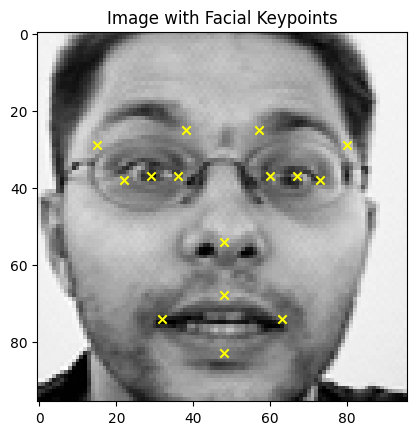

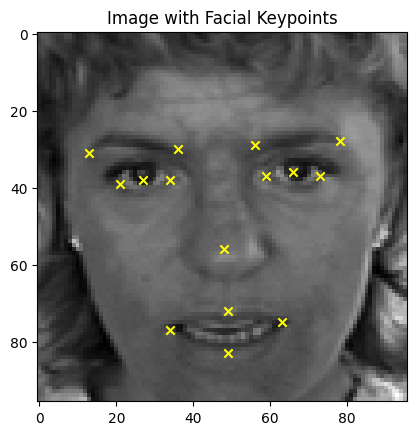

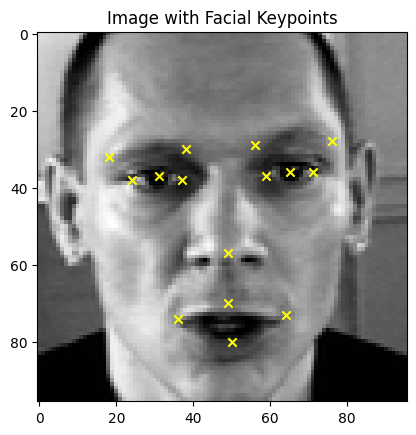

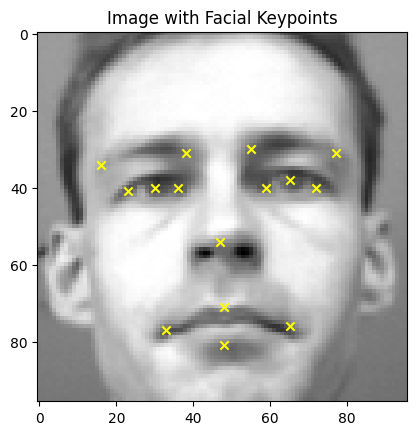

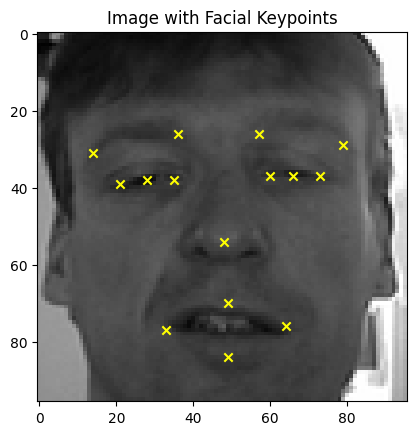

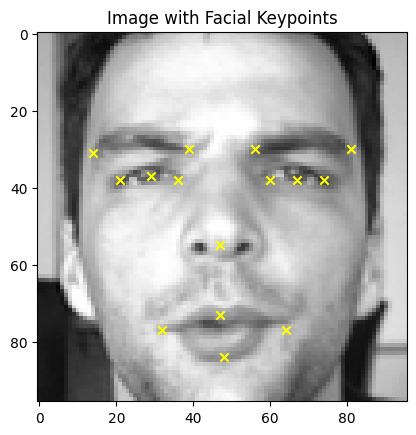

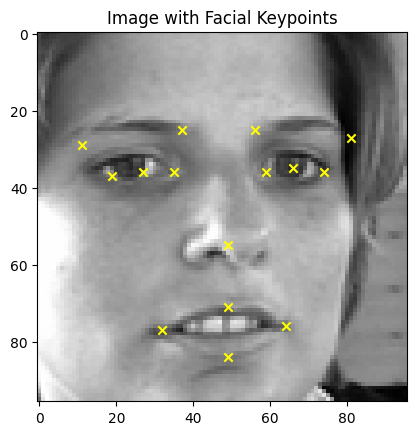

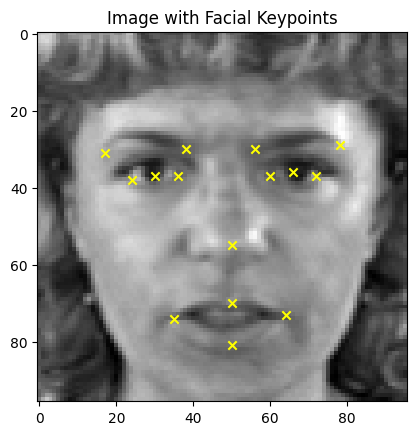

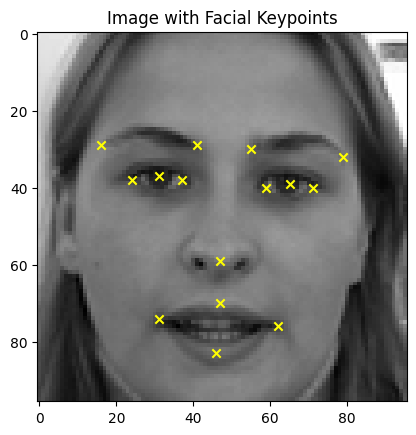

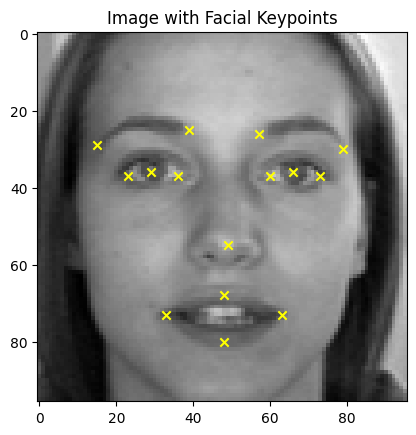

In [12]:
import matplotlib.pyplot as plt
for n in range(10):
  t=[int(i) for i in predict[n]*96]
  image=test_images[n]*255
  plt.imshow(image, cmap='gray')
  plt.scatter(t[0::2], t[1::2], c='yellow', marker='x')
  plt.title("Image with Facial Keypoints")
  plt.show()